In [12]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
mobile = tf.keras.applications.mobilenet.MobileNet()

In [14]:
def prepare_image(file):
    img_path = 'data1/mobile/'
    img = image.load_img(img_path + file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

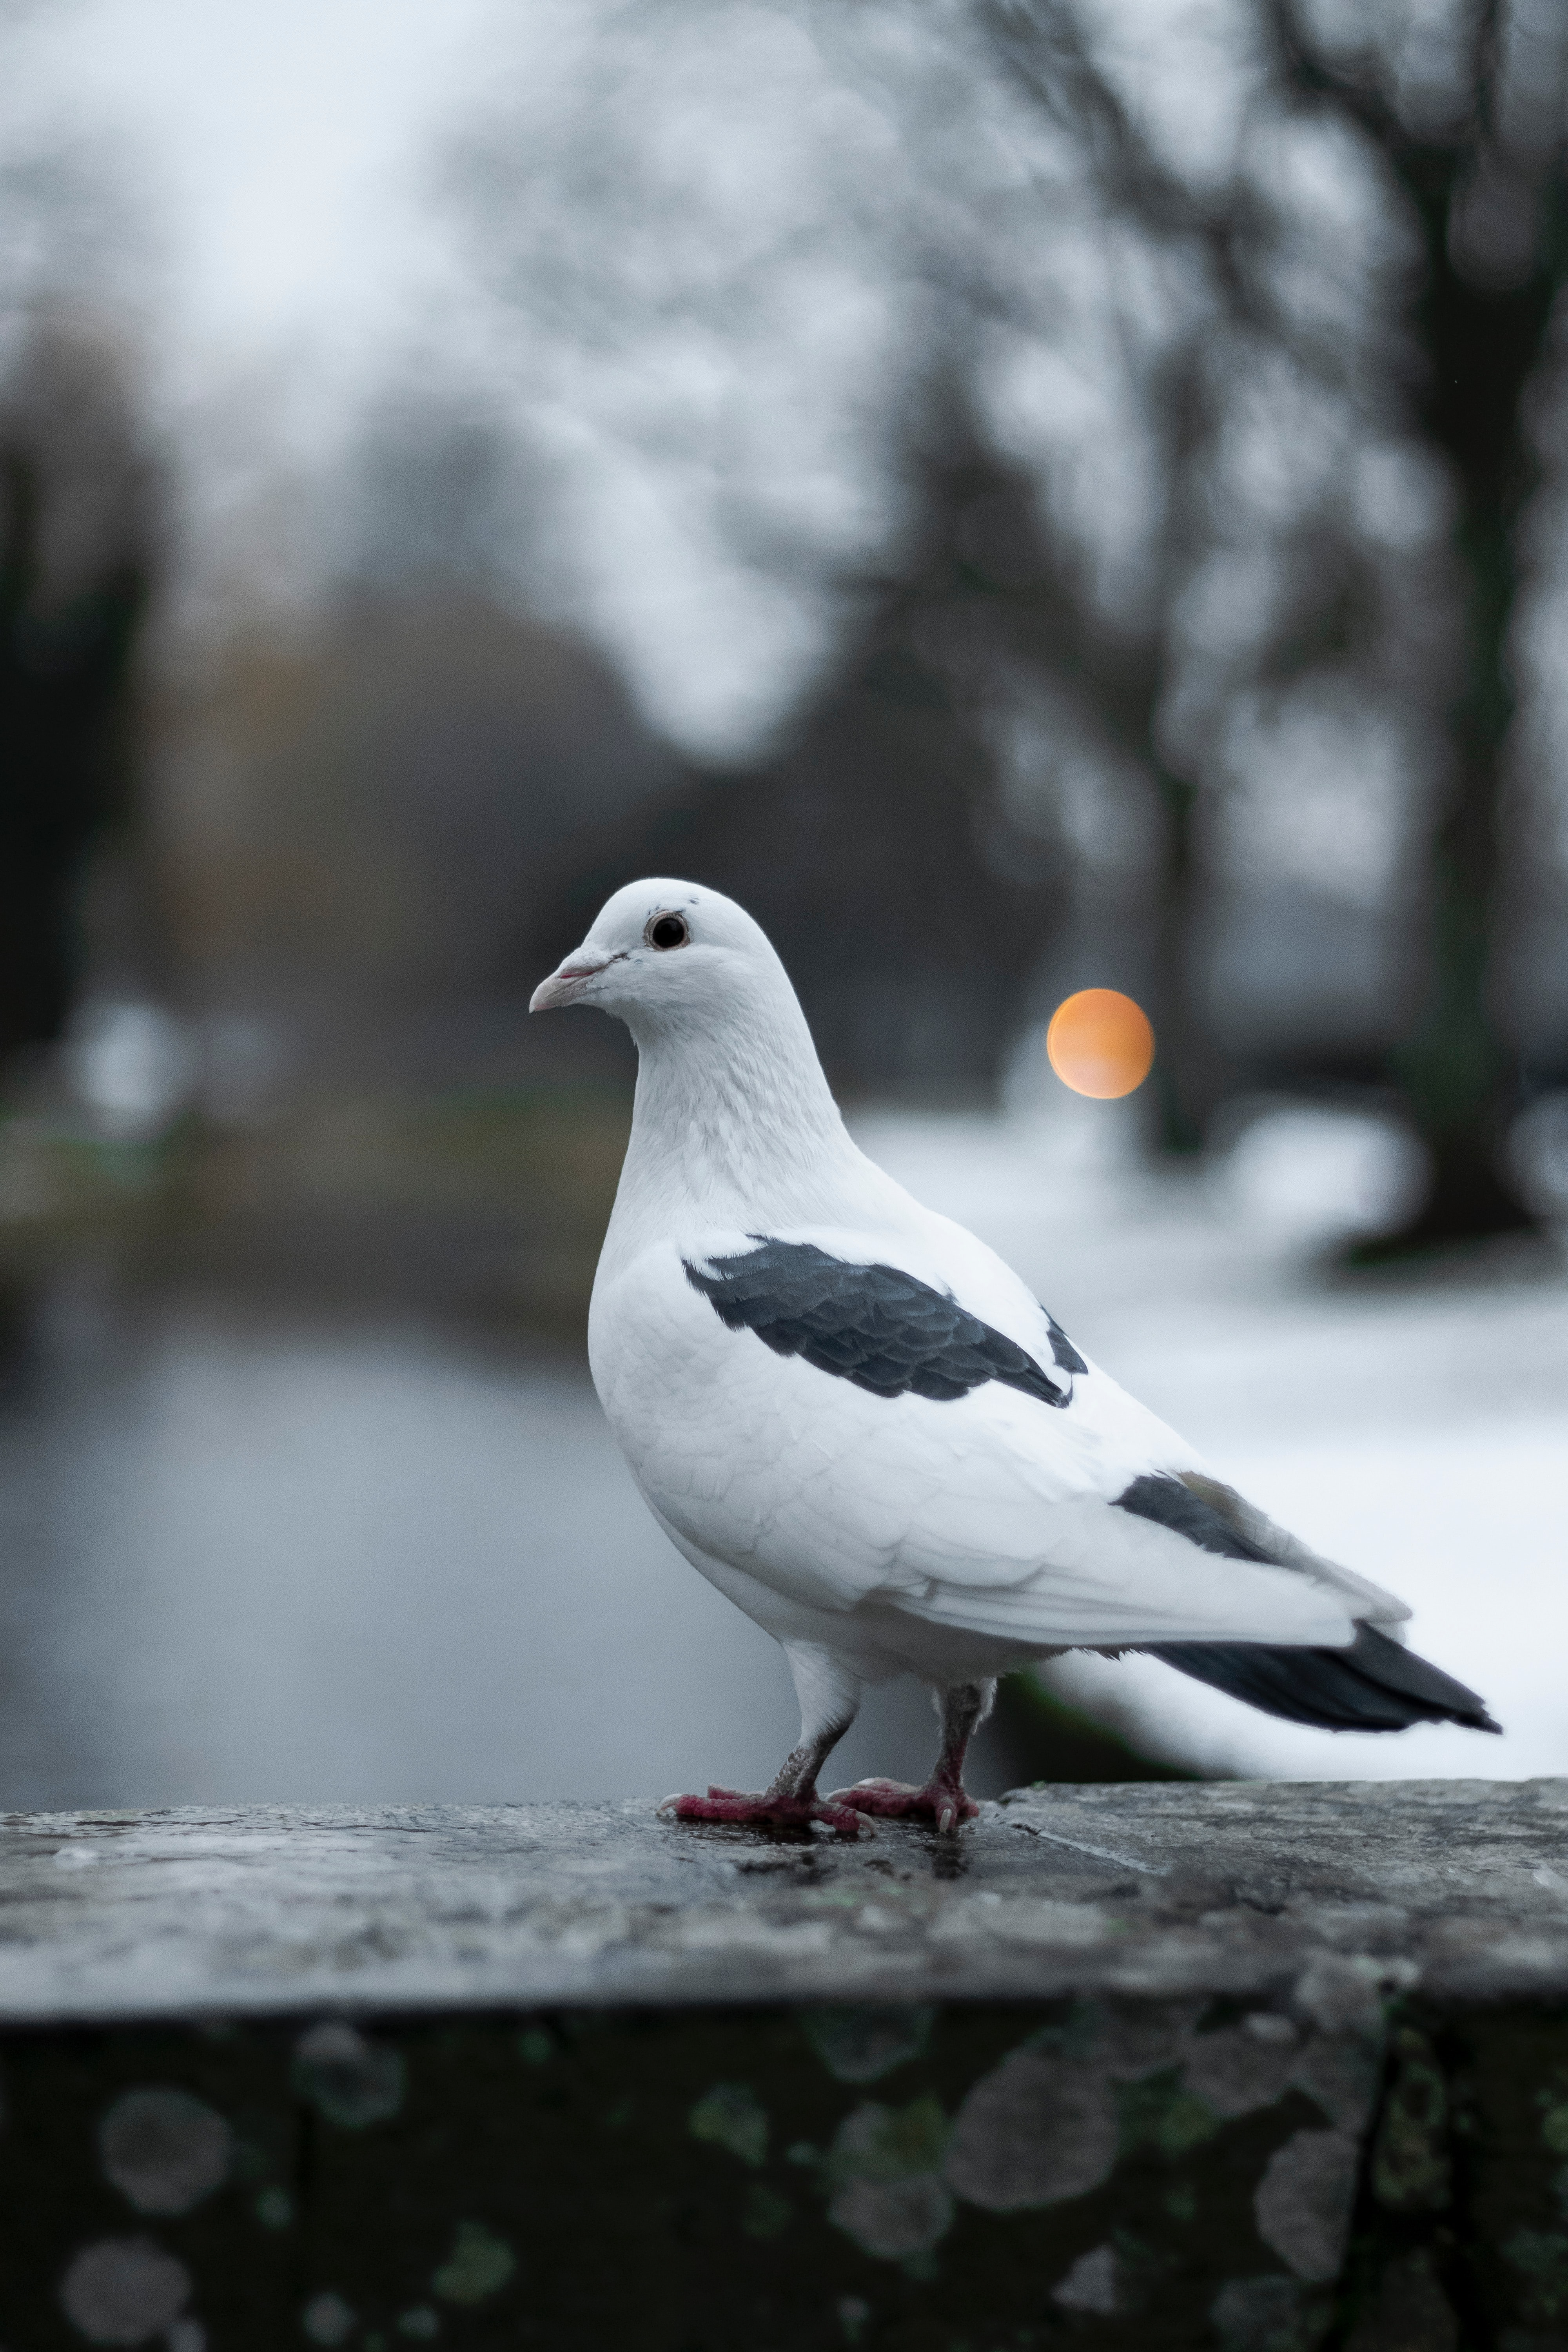

In [15]:
from IPython.display import Image
Image(filename='data1/mobile/1.jpg', width=300,height=200) 

In [16]:
preprocessed_image = prepare_image('1.jpg')
predictions = mobile.predict(preprocessed_image)

In [17]:
results = imagenet_utils.decode_predictions(predictions)
results

[[('n01796340', 'ptarmigan', 0.63583744),
  ('n01601694', 'water_ouzel', 0.25902882),
  ('n01534433', 'junco', 0.026061652),
  ('n02058221', 'albatross', 0.014053173),
  ('n01582220', 'magpie', 0.012736646)]]

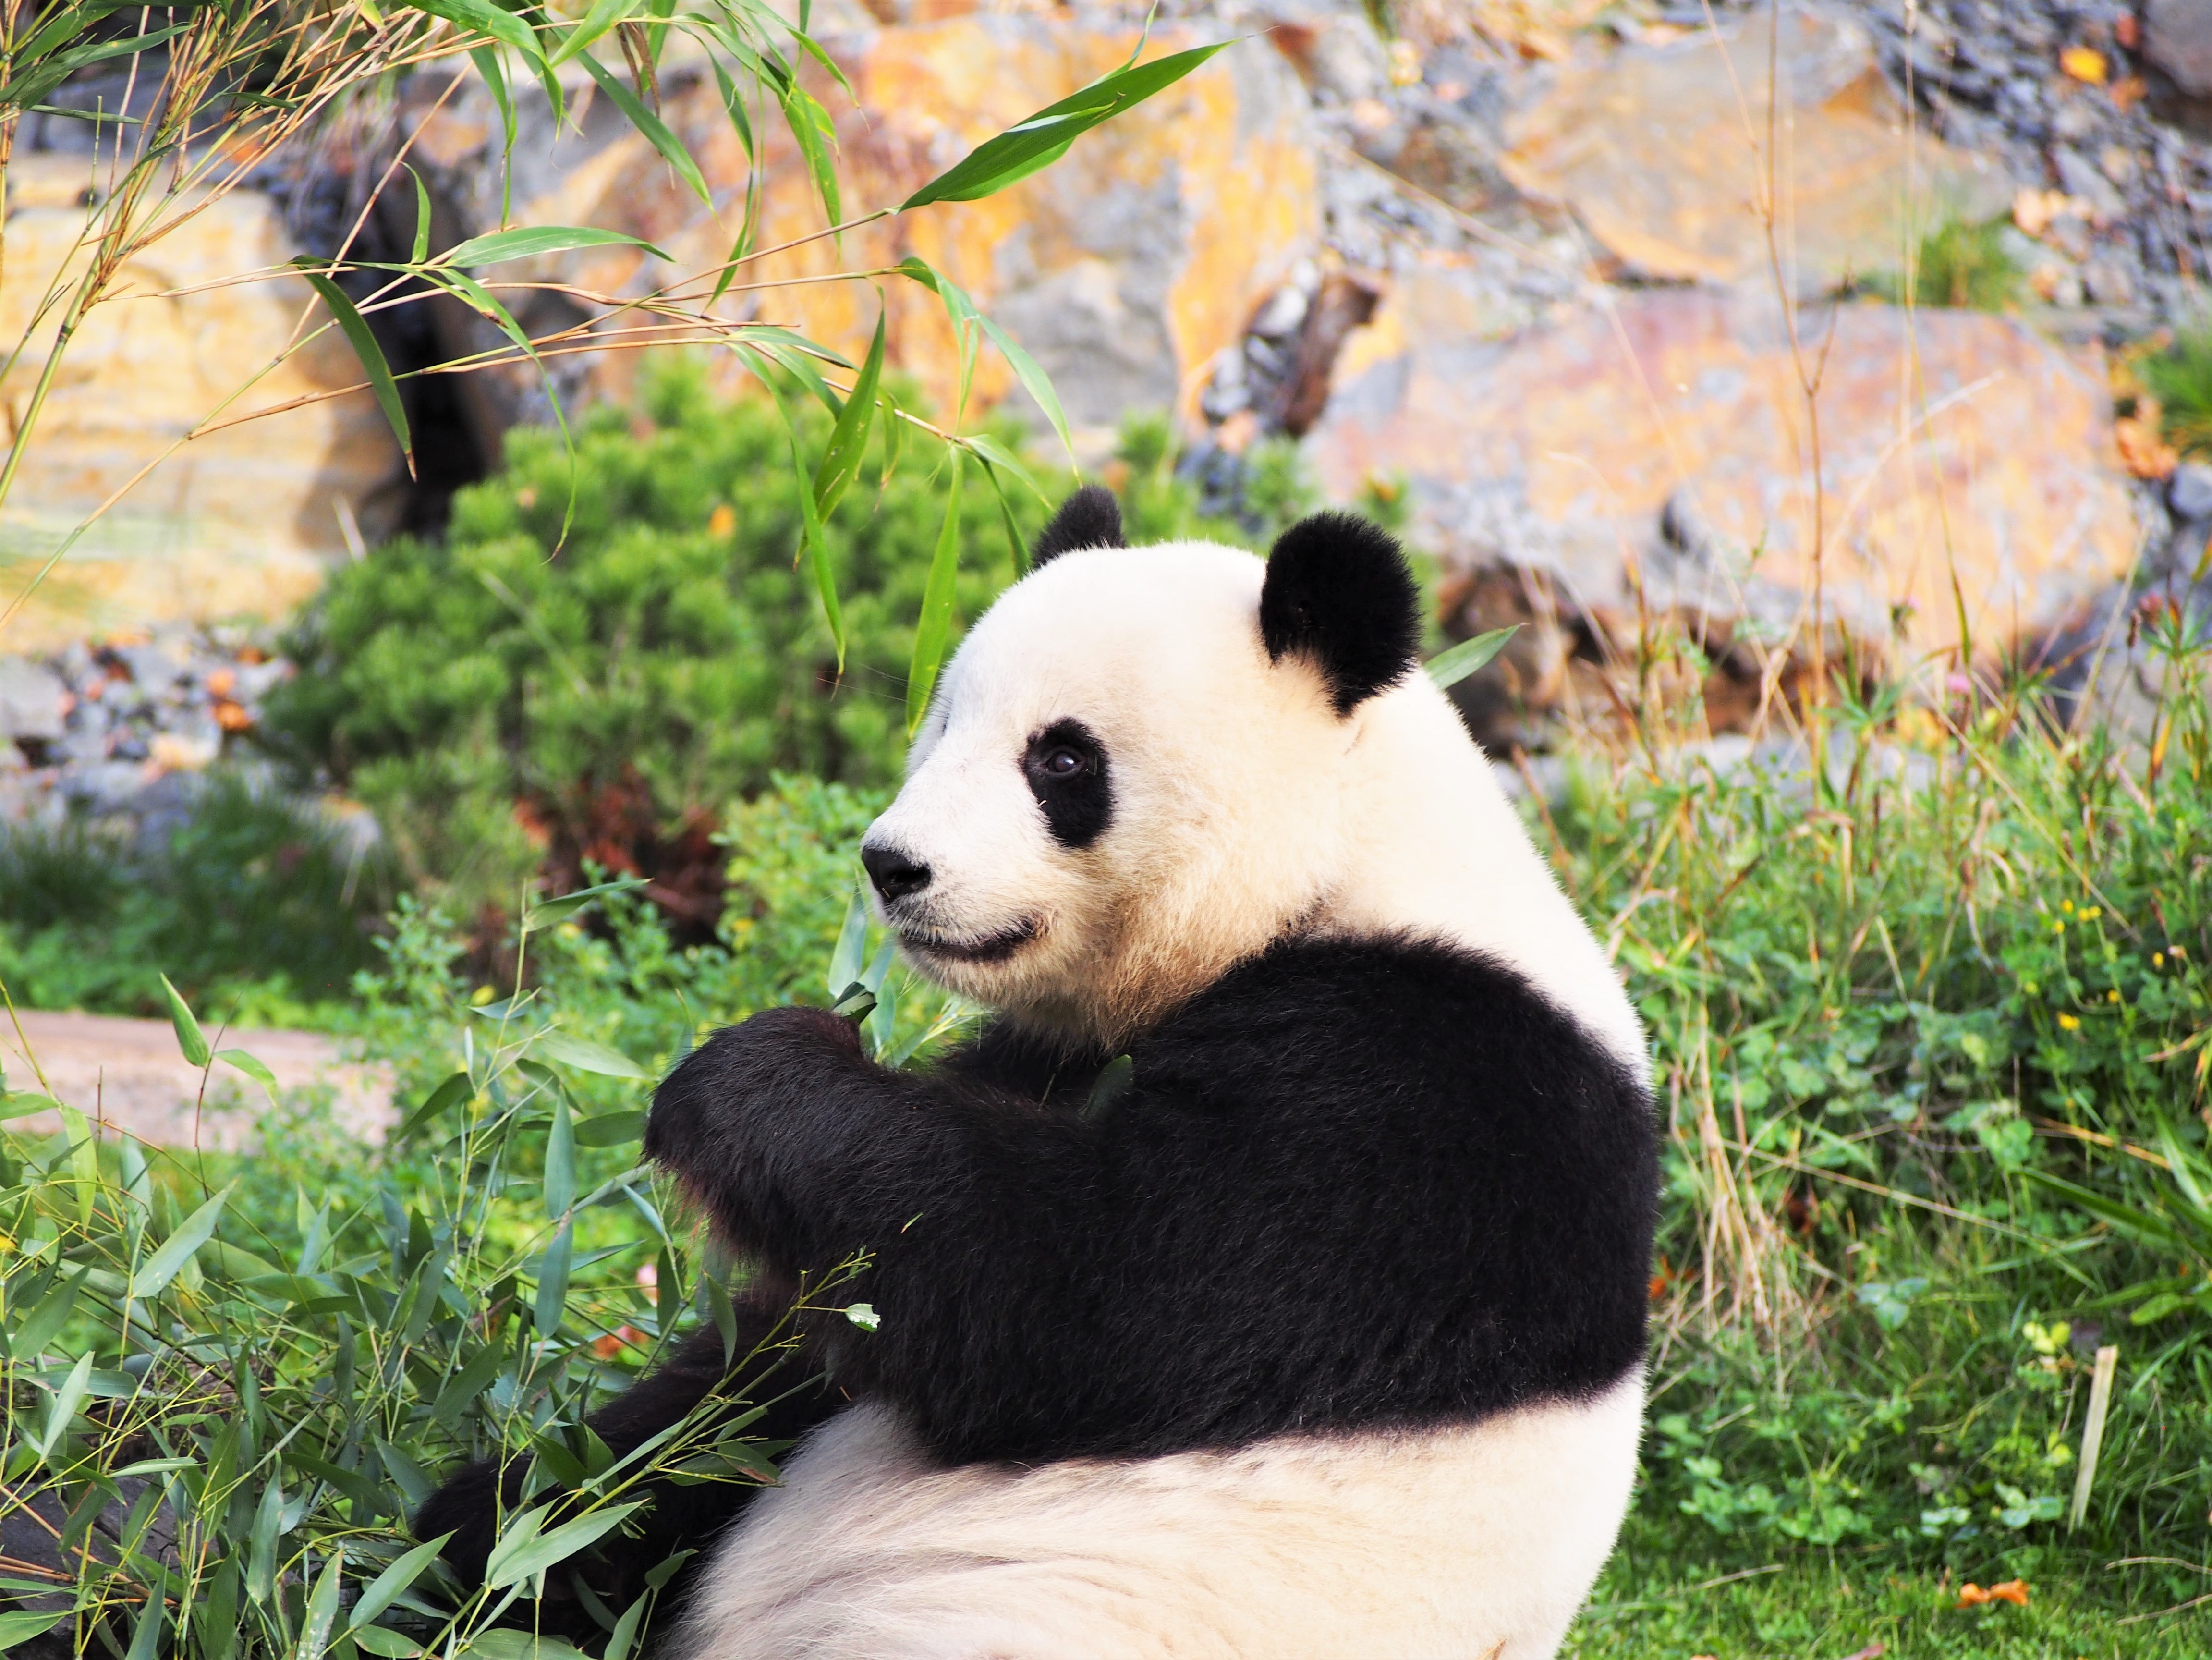

In [18]:
from IPython.display import Image
Image(filename='data1/mobile/2.jpg', width=300,height=200) 

In [19]:
preprocessed_image = prepare_image('2.jpg')
predictions = mobile.predict(preprocessed_image)

In [20]:
results = imagenet_utils.decode_predictions(predictions)
results

[[('n02510455', 'giant_panda', 0.99988127),
  ('n02500267', 'indri', 3.39205e-05),
  ('n02447366', 'badger', 1.20313725e-05),
  ('n02445715', 'skunk', 9.385935e-06),
  ('n04254680', 'soccer_ball', 9.31419e-06)]]

In [21]:
#Process Images for Fine-Tuned MobileNet with TensorFlow's Keras API 

In [22]:
# Organize data into train, valid, test dirs
os.chdir('data2/sign')
if os.path.isdir('train/0/') is False: 
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')

    for i in range(0, 10):
        shutil.move(f'{i}', 'train')
        os.mkdir(f'valid/{i}')
        os.mkdir(f'test/{i}')

        valid_samples = random.sample(os.listdir(f'train/{i}'), 30)
        for j in valid_samples:
            shutil.move(f'train/{i}/{j}', f'valid/{i}')

        test_samples = random.sample(os.listdir(f'train/{i}'), 5)
        for k in test_samples:
            shutil.move(f'train/{i}/{k}', f'test/{i}')
os.chdir('../..')

In [23]:
train_path = 'data2/sign/train'
valid_path = 'data2/sign/valid'
test_path = 'data2/sign/test'



In [24]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


In [25]:
#data preprocessing

In [26]:
mobile = tf.keras.applications.mobilenet.MobileNet()
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

In [27]:
x = mobile.layers[-6].output

In [28]:
output = Dense(units=10, activation='softmax')(x)

In [29]:
model = Model(inputs=mobile.input, outputs=output)

In [30]:
for layer in model.layers[:-23]:
    layer.trainable = False

In [31]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

In [33]:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
model.fit(x=train_batches,
            steps_per_epoch=len(train_batches),
            validation_data=valid_batches,
            validation_steps=len(valid_batches),
            epochs=30,
            verbose=2
)

Epoch 1/30
172/172 - 99s - loss: 0.6541 - accuracy: 0.8131 - val_loss: 0.3238 - val_accuracy: 0.9100
Epoch 2/30
172/172 - 89s - loss: 0.1157 - accuracy: 0.9831 - val_loss: 0.1320 - val_accuracy: 0.9567
Epoch 3/30
172/172 - 93s - loss: 0.0616 - accuracy: 0.9918 - val_loss: 0.0742 - val_accuracy: 0.9833
Epoch 4/30
172/172 - 90s - loss: 0.0353 - accuracy: 0.9953 - val_loss: 0.0891 - val_accuracy: 0.9667
Epoch 5/30
172/172 - 104s - loss: 0.0248 - accuracy: 0.9994 - val_loss: 0.0547 - val_accuracy: 0.9833
Epoch 6/30
172/172 - 107s - loss: 0.0168 - accuracy: 0.9994 - val_loss: 0.0530 - val_accuracy: 0.9767
Epoch 7/30
172/172 - 107s - loss: 0.0111 - accuracy: 0.9994 - val_loss: 0.0406 - val_accuracy: 0.9867
Epoch 8/30
172/172 - 111s - loss: 0.0105 - accuracy: 0.9988 - val_loss: 0.0431 - val_accuracy: 0.9800
Epoch 9/30
172/172 - 102s - loss: 0.0096 - accuracy: 1.0000 - val_loss: 0.0371 - val_accuracy: 0.9900
Epoch 10/30
172/172 - 110s - loss: 0.0087 - accuracy: 0.9994 - val_loss: 0.0290 - val_

In [ ]:
test_labels = test_batches.classes

In [ ]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
test_batches.class_indices

In [ ]:
cm_plot_labels = ['0','1','2','3','4','5','6','7','8','9']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')